# Translational mechanical system

## Introduction
This notebook works through the first example in @Akbaba2022, which is the translational mechanical system. The mechaninical system consists of three masses, springs, damping elements and sliding friction. 


shown in @fig-translational-mech-sys-fig-1-2. 


[Mechanical–electrical analogies](https://en.wikipedia.org/wiki/Mechanical%E2%80%93electrical_analogies)

| A translational mechanical system | |
| A rotational electromechanical system | |
| Mechanical systems | electric circuit analogs |
Electric Circuit-Based Modeling and Analysis of the Translational, Rotational Mechanical and Electromechanical Systems Dynamics

See @Akbaba2022

## Translational mechanical system

![The mechanical and electrical schematic for the mechanical system under consideration is shown. The Figure is from @Akbaba2022, licensed under Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 License.](Translational-mech-sys-fig-1-2.png){#fig-translational-mech-sys-fig-1-2}


A. APPLICATION EXAMPLE 1: MODELING AND ANALYSIS OF A COMPLEX TRANSLATIONAL SYSTEM USING ELECTRIC CIRCUIT EQUIVALENT

System parameters for mechanical system given below in Figure 1 are: 

- Mechanical Load Mass (M1 = 100 kg, M2 = 40 kg, M3 = 80 kg), 
- Stiffness Element (K1 = 500 N/m, K2 = 250 N/m, K3 = 150 N/m, K4 = 300 N/m, K5 = 200 N/m, K6 = 180 N/m, Keq = k1 + k2 )
- Viscous Friction (B1 = 80 N.s/m, B2 = 30 N.s/m, B3 = 50 N.s/m, B4 = 40 N.s/m, B5 = 10 N.s/m, B6 = 30 N.s/m, B7 = 20 N.s/m). 
- The applied force is taken as F(t) = 400sin(4t)e^(−0.1 t).




### Circuit description

![Schematic](translational-mech-sys.png){#fig-translational-mech-sys}

```
Net list report
number of lines in netlist: 16
number of branches: 16
number of nodes: 11
number of unknown currents: 4
number of RLC (passive components): 15
number of inductors: 3
number of independent voltage sources: 1
number of independent current sources: 0
number of op amps: 0
number of E - VCVS: 0
number of G - VCCS: 0
number of F - CCCS: 0
number of H - CCVS: 0
number of K - Coupled inductors: 0
```


```
* C:\users\jeff64\My Documents\Electric circuit analog\transilation-mech-sys.asc
V1 1 0 1
C1 1 2 0.002
Ceq 3 4 0.0025
C4 4 5 0.0033333
C5 7 8 0.005
C6 9 10 0.005555
R1 2 0 80
R2 5 0 30
R3 3 4 50
R4 7 4 40
R5 8 6 10
R7 11 8 20
R6 11 10 30
L1 1 3 100
L3 3 9 80
L2 5 6 40
* Translational mechanical system
.backanno
.end

```


### Circuit analysis
The circuit analysis follows the steps listed below.

- Draw circuit in LTSpice, export netlist
- Generate network equations
- Symbolic solution
- AC sweep and plot the frequency response at the output
- Transient analysis
  - Generate input signal for transient analysis
  - Mostly following the procedure outlined [here](https://stackoverflow.com/questions/77876224/calculating-inverse-laplace-transform-using-python-or-matlab)
  - display the results

Transient analysis is somewhat more involved than the other types of circuit analysis, primarily because SymPy's inverse Laplace transform is not very robust and can't handle complicated expressions. The output equation needs to be simplified by writing some code to put the equation into forms that SymPy can deal with. 


Analysis not agreeing with LTSpice


Load the following Python modules.

In [1]:
from sympy import *
import numpy as np
from tabulate import tabulate
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import SymMNA
from IPython.display import display, Markdown, Math, Latex
init_printing()

### Load the netlist
The netlist generated by LTSpice 

need to set inductors equal to 2 for inverse Laplace to run.

B = R
K = 1/C
M = L

(B1 = 80 N.s/m, B2 = 30 N.s/m, B3 = 50 N.s/m, B4 = 40 N.s/m, B5 = 10 N.s/m, B6 = 30 N.s/m, B7 = 20 N.s/m)  
(R1 = 80, R2 = 30, R3 = 50, R4 = 40, R5 = 10, R6 = 30, R7 = 20)

(M1 = 100 kg, M2 = 40 kg, M3 = 80 kg)  
(L1 = 100, L2 = 40, L3 = 80)  

1/K = C
(K1 = 500 N/m, K2 = 250 N/m, K3 = 150 N/m, K4 = 300 N/m, K5 = 200 N/m, K6 = 180 N/m, Keq = k1 + k2 )  
(C1 = 500, C2 = 250, C33 = 150, C4 = 300, C5 = 200, C6 = 180, Ceq = k1 + k2 )


In [2]:
net_list = '''
V1 1 0 1
C1 1 2 1
Ceq 3 4 1
C4 4 5 1
C5 7 8 1
C6 9 10 1
R1 2 0 1
R2 5 0 1
R3 3 4 1
R4 7 4 1
R5 8 6 1
R7 11 8 1
R6 11 10 1
L1 1 3 1
L3 3 9 1
L2 6 5 1
'''

Generate the network equations.

In [3]:
report, network_df, df2, A, X, Z = SymMNA.smna(net_list)

# Put matricies into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

In [4]:
print(report)

Net list report
number of lines in netlist: 16
number of branches: 16
number of nodes: 11
number of unknown currents: 4
number of RLC (passive components): 15
number of inductors: 3
number of independent voltage sources: 1
number of independent current sources: 0
number of op amps: 0
number of E - VCVS: 0
number of G - VCCS: 0
number of F - CCCS: 0
number of H - CCVS: 0
number of K - Coupled inductors: 0



Generate markdown text to display the network equations.

In [5]:
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*X)[i:i+1][0],Z[i])))

Markdown(temp)

$C_{1} s v_{1} - C_{1} s v_{2} + I_{L1} + I_{V1} = 0$<br>$- C_{1} s v_{1} + v_{2} \left(C_{1} s + \frac{1}{R_{1}}\right) = 0$<br>$- I_{L1} + I_{L3} + v_{3} \left(Ceq s + \frac{1}{R_{3}}\right) + v_{4} \left(- Ceq s - \frac{1}{R_{3}}\right) = 0$<br>$- C_{4} s v_{5} + v_{3} \left(- Ceq s - \frac{1}{R_{3}}\right) + v_{4} \left(C_{4} s + Ceq s + \frac{1}{R_{4}} + \frac{1}{R_{3}}\right) - \frac{v_{7}}{R_{4}} = 0$<br>$- C_{4} s v_{4} - I_{L2} + v_{5} \left(C_{4} s + \frac{1}{R_{2}}\right) = 0$<br>$I_{L2} + \frac{v_{6}}{R_{5}} - \frac{v_{8}}{R_{5}} = 0$<br>$- C_{5} s v_{8} + v_{7} \left(C_{5} s + \frac{1}{R_{4}}\right) - \frac{v_{4}}{R_{4}} = 0$<br>$- C_{5} s v_{7} + v_{8} \left(C_{5} s + \frac{1}{R_{7}} + \frac{1}{R_{5}}\right) - \frac{v_{11}}{R_{7}} - \frac{v_{6}}{R_{5}} = 0$<br>$- C_{6} s v_{10} + C_{6} s v_{9} - I_{L3} = 0$<br>$- C_{6} s v_{9} + v_{10} \left(C_{6} s + \frac{1}{R_{6}}\right) - \frac{v_{11}}{R_{6}} = 0$<br>$v_{11} \cdot \left(\frac{1}{R_{7}} + \frac{1}{R_{6}}\right) - \frac{v_{8}}{R_{7}} - \frac{v_{10}}{R_{6}} = 0$<br>$v_{1} = V_{1}$<br>$- I_{L1} L_{1} s + v_{1} - v_{3} = 0$<br>$- I_{L3} L_{3} s + v_{3} - v_{9} = 0$<br>$- I_{L2} L_{2} s - v_{5} + v_{6} = 0$<br>

As shown above MNA generated many equations and these would be difficult to solve by hand.

The sysmbols generated by the Python code are extraced by the SymPy function free_symbols and then declared as SymPy variables. 

In [6]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

### Symbolic solution
Since the circuit is large, a symbolic solution takes a long time, so code is commented out.

In [7]:
#U_sym = solve(NE_sym,X)

Display the symbolic solution

In [8]:
#temp = ''
#for i in U_sym.keys():
#    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

#Markdown(temp)

### Numerical solution
Built a dictionary of element values.

In [9]:
t = symbols('t',positive=True)  # t > 0

In [10]:
element_values = SymMNA.get_part_values(network_df)
element_values

R's

(B1 = 80 N.s/m, B2 = 30 N.s/m, B3 = 50 N.s/m, B4 = 40 N.s/m, B5 = 10 N.s/m, B6 = 30 N.s/m, B7 = 20 N.s/m)  

(R1 = 80, R2 = 30, R3 = 50, R4 = 40, R5 = 10, R6 = 30, R7 = 20)

In [11]:
B1 = 80
B2 = 30
B3 = 50
B4 = 40
B5 = 10
B6 = 30
B7 = 20
element_values[R1] = B1
element_values[R2] = B2
element_values[R3] = B3
element_values[R4] = B4
element_values[R5] = B5
element_values[R6] = B6
element_values[R7] = B7

L's  

(M1 = 100 kg, M2 = 40 kg, M3 = 80 kg)  

(L1 = 100, L2 = 40, L3 = 80) 

In [12]:
M1 = 100
M2 = 40
M3 = 80
element_values[L1] = M1
element_values[L2] = M2
element_values[L3] = M3

Using C = 1/K

1/K = C

(K1 = 500 N/m, K2 = 250 N/m, K3 = 150 N/m, K4 = 300 N/m, K5 = 200 N/m, K6 = 180 N/m, Keq = k1 + k2 )  

(C1 = 500, C2 = 250, C3 = 150, C4 = 300, C5 = 200, C6 = 180, Ceq = k1 + k2 )

In [13]:
K1 = 500
K2 = 250
K3 = 150
K4 = 300
K5 = 200
K6 = 180
Keq = K1 + K2 

element_values[C1] = 1/K1
element_values[C4] = 1/K4
element_values[C5] = 1/K5
element_values[C6] = 1/K6
element_values[Ceq] = 1/Keq

In [14]:
element_values

Driving function

$V_1 = 400 e^{-0.1*t} sin(4*t)$

In [15]:
#element_values[V1] = laplace_transform(1*Heaviside(t), t, s)[0] # step function as a test
element_values[V1] = laplace_transform(400*exp(-0.1*t)*sin(4*t), t, s)[0] # driving function in example
NE = NE_sym.subs(element_values)
NE

⎡                                 I_L1 + I_V1 + 0.002⋅s⋅v₁ - 0.002⋅s⋅v₂       
⎢                                                                             
⎢                                   -0.002⋅s⋅v₁ + v₂⋅(0.002⋅s + 1/80)         
⎢                                                                             
⎢         -I_L1 + I_L3 + v₃⋅(0.00133333333333333⋅s + 1/50) + v₄⋅(-0.0013333333
⎢                                                                             
⎢                                                                             
⎢-0.00333333333333333⋅s⋅v₅ + v₃⋅(-0.00133333333333333⋅s - 1/50) + v₄⋅(0.004666
⎢                                                                             
⎢                                                                             
⎢                  -I_L2 - 0.00333333333333333⋅s⋅v₄ + v₅⋅(0.00333333333333333⋅
⎢                                                                             
⎢                                                   

In [16]:
U = solve(NE,X)

temp = ''
for i in U.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U[i]))

Markdown(temp)

$v_{1} = \frac{160000.0}{100.0 s^{2} + 20.0 s + 1601.0}$<br>$v_{2} = \frac{640000.0 s}{400.0 s^{3} + 2580.0 s^{2} + 6904.0 s + 40025.0}$<br>$v_{3} = \frac{15360000.0 s^{6} + 804480000.0 s^{5} + 4550880000.0 s^{4} + 20114400000.0 s^{3} + 36216000000.0 s^{2} + 38448000000.0 s + 25920000000.0}{32000.0 s^{9} + 572000.0 s^{8} + 3149240.0 s^{7} + 21974316.0 s^{6} + 67910398.0 s^{5} + 248892243.0 s^{4} + 433651215.0 s^{3} + 743617350.0 s^{2} + 387960300.0 s + 259362000.0}$<br>$v_{4} = \frac{15360000.0 s^{6} + 420480000.0 s^{5} + 3638880000.0 s^{4} + 13142400000.0 s^{3} + 31896000000.0 s^{2} + 27648000000.0 s + 25920000000.0}{32000.0 s^{9} + 572000.0 s^{8} + 3149240.0 s^{7} + 21974316.0 s^{6} + 67910398.0 s^{5} + 248892243.0 s^{4} + 433651215.0 s^{3} + 743617350.0 s^{2} + 387960300.0 s + 259362000.0}$<br>$v_{5} = \frac{15360000.0 s^{6} + 266880000.0 s^{5} + 970080000.0 s^{4} + 4593600000.0 s^{3} + 5976000000.0 s^{2} + 10800000000.0 s}{32000.0 s^{9} + 572000.0 s^{8} + 3149240.0 s^{7} + 21974316.0 s^{6} + 67910398.0 s^{5} + 248892243.0 s^{4} + 433651215.0 s^{3} + 743617350.0 s^{2} + 387960300.0 s + 259362000.0}$<br>$v_{6} = \frac{15360000.0 s^{6} + 420480000.0 s^{5} + 3638880000.0 s^{4} + 10315200000.0 s^{3} + 16920000000.0 s^{2} + 10800000000.0 s}{32000.0 s^{9} + 572000.0 s^{8} + 3149240.0 s^{7} + 21974316.0 s^{6} + 67910398.0 s^{5} + 248892243.0 s^{4} + 433651215.0 s^{3} + 743617350.0 s^{2} + 387960300.0 s + 259362000.0}$<br>$v_{7} = \frac{15360000.0 s^{6} + 420480000.0 s^{5} + 3677280000.0 s^{4} + 10790400000.0 s^{3} + 30110400000.0 s^{2} + 22464000000.0 s + 25920000000.0}{32000.0 s^{9} + 572000.0 s^{8} + 3149240.0 s^{7} + 21974316.0 s^{6} + 67910398.0 s^{5} + 248892243.0 s^{4} + 433651215.0 s^{3} + 743617350.0 s^{2} + 387960300.0 s + 259362000.0}$<br>$v_{8} = \frac{15360000.0 s^{6} + 420480000.0 s^{5} + 3677280000.0 s^{4} + 10982400000.0 s^{3} + 18350400000.0 s^{2} + 13536000000.0 s}{32000.0 s^{9} + 572000.0 s^{8} + 3149240.0 s^{7} + 21974316.0 s^{6} + 67910398.0 s^{5} + 248892243.0 s^{4} + 433651215.0 s^{3} + 743617350.0 s^{2} + 387960300.0 s + 259362000.0}$<br>$v_{9} = \frac{15360000.0 s^{6} + 420480000.0 s^{5} + 3917280000.0 s^{4} + 12242400000.0 s^{3} + 24696000000.0 s^{2} + 38448000000.0 s + 25920000000.0}{32000.0 s^{9} + 572000.0 s^{8} + 3149240.0 s^{7} + 21974316.0 s^{6} + 67910398.0 s^{5} + 248892243.0 s^{4} + 433651215.0 s^{3} + 743617350.0 s^{2} + 387960300.0 s + 259362000.0}$<br>$v_{10} = \frac{15360000.0 s^{6} + 420480000.0 s^{5} + 3917280000.0 s^{4} + 11378400000.0 s^{3} + 23270400000.0 s^{2} + 20736000000.0 s}{32000.0 s^{9} + 572000.0 s^{8} + 3149240.0 s^{7} + 21974316.0 s^{6} + 67910398.0 s^{5} + 248892243.0 s^{4} + 433651215.0 s^{3} + 743617350.0 s^{2} + 387960300.0 s + 259362000.0}$<br>$v_{11} = \frac{15360000.0 s^{6} + 420480000.0 s^{5} + 3773280000.0 s^{4} + 11140800000.0 s^{3} + 20318400000.0 s^{2} + 16416000000.0 s}{32000.0 s^{9} + 572000.0 s^{8} + 3149240.0 s^{7} + 21974316.0 s^{6} + 67910398.0 s^{5} + 248892243.0 s^{4} + 433651215.0 s^{3} + 743617350.0 s^{2} + 387960300.0 s + 259362000.0}$<br>$I_{V1} = \frac{- 2560000.0 s^{8} - 47296000.0 s^{7} - 250288000.0 s^{6} - 1344888000.0 s^{5} - 3422600000.0 s^{4} - 8235600000.0 s^{3} - 8342400000.0 s^{2} - 10296000000.0 s}{128000.0 s^{10} + 3088000.0 s^{9} + 26896960.0 s^{8} + 166628264.0 s^{7} + 820999492.0 s^{6} + 2693328922.0 s^{5} + 7956910935.0 s^{4} + 13815749775.0 s^{3} + 20142274950.0 s^{2} + 10736455500.0 s + 6484050000.0}$<br>$I_{L1} = \frac{512000.0 s^{6} + 8896000.0 s^{5} + 32336000.0 s^{4} + 153120000.0 s^{3} + 199200000.0 s^{2} + 360000000.0 s}{32000.0 s^{9} + 572000.0 s^{8} + 3149240.0 s^{7} + 21974316.0 s^{6} + 67910398.0 s^{5} + 248892243.0 s^{4} + 433651215.0 s^{3} + 743617350.0 s^{2} + 387960300.0 s + 259362000.0}$<br>$I_{L3} = \frac{4800000.0 s^{4} + 7920000.0 s^{3} + 98400000.0 s^{2} + 144000000.0 s}{32000.0 s^{9} + 572000.0 s^{8} + 3149240.0 s^{7} + 21974316.0 s^{6} + 67910398.0 s^{5} + 248892243.0 s^{4} + 433651215.0 s^{3} + 743617350.0 s^{2} + 387960300.0 s + 259362000.0}$<br>$I_{L2} = \frac{3840000.0 s^{4} + 66720000.0 s^{3} + 143040000.0 s^{2} + 273600000.0 s}{32000.0 s^{9} + 572000.0 s^{8} + 3149240.0 s^{7} + 21974316.0 s^{6} + 67910398.0 s^{5} + 248892243.0 s^{4} + 433651215.0 s^{3} + 743617350.0 s^{2} + 387960300.0 s + 259362000.0}$<br>

## Inductor current
equalivent to velocity

### L1 current
L1 current is equalivent to displacement. The current through L1 is symplified with the chain of operators applied to the expression; [nsimplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#sympy.simplify.simplify.nsimplify), [simplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#simplify), [expand()](https://docs.sympy.org/latest/modules/core.html#sympy.core.function.expand) and [together()](https://docs.sympy.org/latest/modules/polys/reference.html#sympy.polys.rationaltools.together). This helps SymPy solve the inverse Laplace transform.

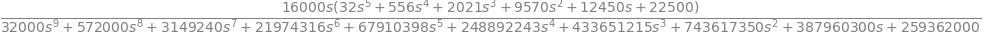

In [323]:
L1_current_s = U[I_L1].nsimplify().simplify().expand().together()
L1_current_s

The inverse Laplace was taking too long, so the lines of code were commented out

In [324]:
#L1_current = inverse_laplace_transform(L1_current_s, s, t)
#L1_current

Using NumPy to obtain the partial fraction expansion, convert back to the s domain and then take the inverse Laplace transform on each term.

Extract the numerator and denominator and display.

In [325]:
n, d = fraction(L1_current_s)
n = n.expand()
Markdown('numerator: ${:s}$<br>denominator: ${:s}$'.format(latex(n),latex(d)))

numerator: $512000 s^{6} + 8896000 s^{5} + 32336000 s^{4} + 153120000 s^{3} + 199200000 s^{2} + 360000000 s$<br>denominator: $32000 s^{9} + 572000 s^{8} + 3149240 s^{7} + 21974316 s^{6} + 67910398 s^{5} + 248892243 s^{4} + 433651215 s^{3} + 743617350 s^{2} + 387960300 s + 259362000$

Each of the numerator terms can be put over the common denominator.

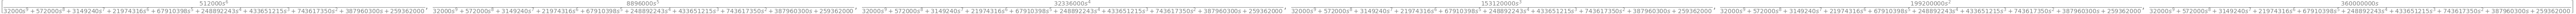

In [326]:
terms = [a / d for a in n.args]
display(terms)

The following code processes each of the terms obtained above. 

- the SciPy function [residue](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.residue.html) is used to get the residues and poles of the partial-fraction expansion
- build the partial expansion terms and find the inverse Laplace of each term and save

Returns:

- r: Residues corresponding to the poles. For repeated poles, the residues are ordered to correspond to ascending by power fractions.
- p: Poles ordered by magnitude in ascending order.
- k: Coefficients of the direct polynomial term.

When computing the inverse Laplace transform, the Coefficients (k) are ignored since these transform to a Dirac delta function, $\delta (t)$ and don't need to be plotted.

In [327]:
N = []

for p1 in terms:

    # use the SciPy residue function to get the partial-fraction expansion residues and poles
    n, d = fraction(p1)
    cn = Poly(n, s).all_coeffs()
    cd = Poly(d, s).all_coeffs()
    r, p, k = signal.residue(cn, cd, tol=0.001, rtype='avg')

    # build a symbolic expression for each of the residues and find the inverse Laplace of each one and save
    z = 0
    for i in range(len(r)):
        m = (r[i]/(s-p[i]))
        z += inverse_laplace_transform(m, s, t)

    N.append(z)

Each of these terms came be converted to a function using SymPy's [lambdify](https://docs.sympy.org/latest/modules/utilities/lambdify.html) function.

Define the values for the x-axis of the plot and put each one into an array for plotting.

In [328]:
x = np.linspace(0, 50, 2000, endpoint=True)
V_node2 = np.zeros(len(x),dtype = complex)
for p in N:
    V_node2 += lambdify(t, p)(x)

Plot the final combined result.

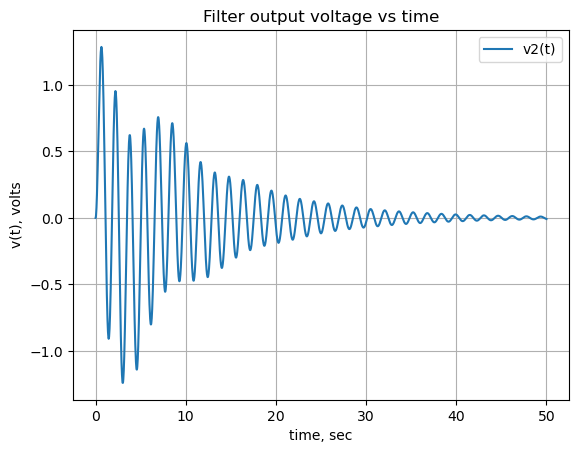

In [329]:
plt.title('Filter output voltage vs time')

plt.plot(x, np.real(V_node2),label='v2(t)')
#plt.plot(x, np.real(func_V1_t(x)),label='V1(t)')

plt.ylabel('v(t), volts')
plt.xlabel('time, sec')

plt.legend()
plt.grid()
plt.show()

### L2 current
L2 current is equalivent to displacement. The current through L2 is symplified with the chain of operators applied to the expression; [nsimplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#sympy.simplify.simplify.nsimplify), [simplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#simplify), [expand()](https://docs.sympy.org/latest/modules/core.html#sympy.core.function.expand) and [together()](https://docs.sympy.org/latest/modules/polys/reference.html#sympy.polys.rationaltools.together). This helps SymPy solve the inverse Laplace transform.

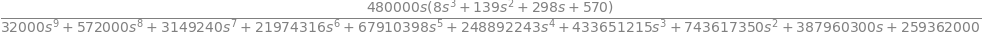

In [330]:
L2_current_s = U[I_L2].nsimplify().simplify().expand().together()
L2_current_s

The inverse Laplace was taking too long, so the lines of code were commented out

In [331]:
#L2_current = inverse_laplace_transform(L2_current_s, s, t)
#L2_current

Using NumPy to obtain the partial fraction expansion, convert back to the s domain and then take the inverse Laplace transform on each term.

Extract the numerator and denominator and display.

In [332]:
n, d = fraction(L2_current_s)
n = n.expand()
Markdown('numerator: ${:s}$<br>denominator: ${:s}$'.format(latex(n),latex(d)))

numerator: $3840000 s^{4} + 66720000 s^{3} + 143040000 s^{2} + 273600000 s$<br>denominator: $32000 s^{9} + 572000 s^{8} + 3149240 s^{7} + 21974316 s^{6} + 67910398 s^{5} + 248892243 s^{4} + 433651215 s^{3} + 743617350 s^{2} + 387960300 s + 259362000$

Each of the numerator terms can be put over the common denominator.

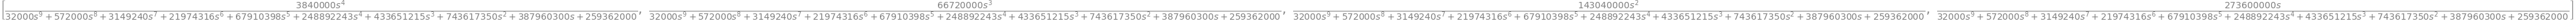

In [333]:
terms = [a / d for a in n.args]
display(terms)

The following code processes each of the terms obtained above. 

- the SciPy function [residue](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.residue.html) is used to get the residues and poles of the partial-fraction expansion
- build the partial expansion terms and find the inverse Laplace of each term and save

Returns:

- r: Residues corresponding to the poles. For repeated poles, the residues are ordered to correspond to ascending by power fractions.
- p: Poles ordered by magnitude in ascending order.
- k: Coefficients of the direct polynomial term.

When computing the inverse Laplace transform, the Coefficients (k) are ignored since these transform to a Dirac delta function, $\delta (t)$ and don't need to be plotted.

In [334]:
N = []

for p1 in terms:

    # use the SciPy residue function to get the partial-fraction expansion residues and poles
    n, d = fraction(p1)
    cn = Poly(n, s).all_coeffs()
    cd = Poly(d, s).all_coeffs()
    r, p, k = signal.residue(cn, cd, tol=0.001, rtype='avg')

    # build a symbolic expression for each of the residues and find the inverse Laplace of each one and save
    z = 0
    for i in range(len(r)):
        m = (r[i]/(s-p[i]))
        z += inverse_laplace_transform(m, s, t)

    N.append(z)

Each of these terms came be converted to a function using SymPy's [lambdify](https://docs.sympy.org/latest/modules/utilities/lambdify.html) function.

Define the values for the x-axis of the plot and put each one into an array for plotting.

In [335]:
x = np.linspace(0, 50, 2000, endpoint=True)
V_node2 = np.zeros(len(x),dtype = complex)
for p in N:
    V_node2 += lambdify(t, p)(x)

Plot the final combined result.

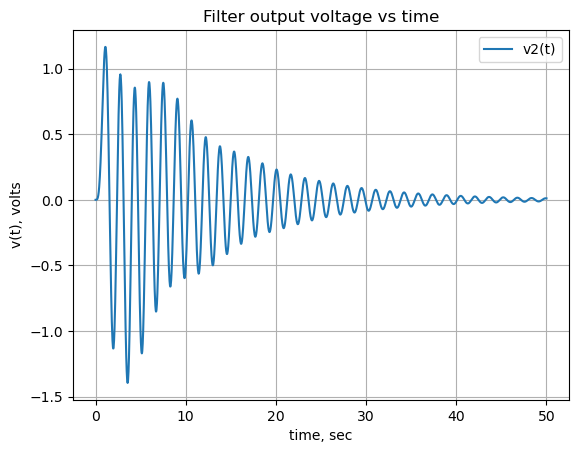

In [336]:
plt.title('Filter output voltage vs time')

plt.plot(x, np.real(V_node2),label='v2(t)')
#plt.plot(x, np.real(func_V1_t(x)),label='V1(t)')

plt.ylabel('v(t), volts')
plt.xlabel('time, sec')

plt.legend()
plt.grid()
plt.show()

### L3 current
L3 current is equalivent to displacement. The current through L3 is symplified with the chain of operators applied to the expression; [nsimplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#sympy.simplify.simplify.nsimplify), [simplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#simplify), [expand()](https://docs.sympy.org/latest/modules/core.html#sympy.core.function.expand) and [together()](https://docs.sympy.org/latest/modules/polys/reference.html#sympy.polys.rationaltools.together). This helps SymPy solve the inverse Laplace transform.

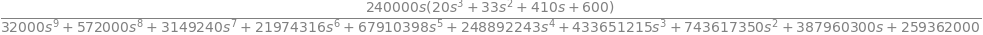

In [337]:
L3_current_s = U[I_L3].nsimplify().simplify().expand().together()
L3_current_s

The inverse Laplace was taking too long, so the lines of code were commented out

In [338]:
#L3_current = inverse_laplace_transform(L3_current_s, s, t)
#L3_current

Using NumPy to obtain the partial fraction expansion, convert back to the s domain and then take the inverse Laplace transform on each term.

Extract the numerator and denominator and display.

In [339]:
n, d = fraction(L3_current_s)
n = n.expand()
Markdown('numerator: ${:s}$<br>denominator: ${:s}$'.format(latex(n),latex(d)))

numerator: $4800000 s^{4} + 7920000 s^{3} + 98400000 s^{2} + 144000000 s$<br>denominator: $32000 s^{9} + 572000 s^{8} + 3149240 s^{7} + 21974316 s^{6} + 67910398 s^{5} + 248892243 s^{4} + 433651215 s^{3} + 743617350 s^{2} + 387960300 s + 259362000$

Each of the numerator terms can be put over the common denominator.

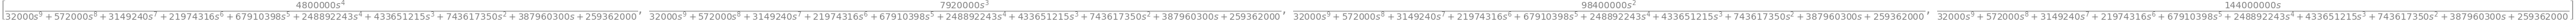

In [340]:
terms = [a / d for a in n.args]
display(terms)

The following code processes each of the terms obtained above. 

- the SciPy function [residue](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.residue.html) is used to get the residues and poles of the partial-fraction expansion
- build the partial expansion terms and find the inverse Laplace of each term and save

Returns:

- r: Residues corresponding to the poles. For repeated poles, the residues are ordered to correspond to ascending by power fractions.
- p: Poles ordered by magnitude in ascending order.
- k: Coefficients of the direct polynomial term.

When computing the inverse Laplace transform, the Coefficients (k) are ignored since these transform to a Dirac delta function, $\delta (t)$ and don't need to be plotted.

In [341]:
N = []

for p1 in terms:

    # use the SciPy residue function to get the partial-fraction expansion residues and poles
    n, d = fraction(p1)
    cn = Poly(n, s).all_coeffs()
    cd = Poly(d, s).all_coeffs()
    r, p, k = signal.residue(cn, cd, tol=0.001, rtype='avg')

    # build a symbolic expression for each of the residues and find the inverse Laplace of each one and save
    z = 0
    for i in range(len(r)):
        m = (r[i]/(s-p[i]))
        z += inverse_laplace_transform(m, s, t)

    N.append(z)

Each of these terms came be converted to a function using SymPy's [lambdify](https://docs.sympy.org/latest/modules/utilities/lambdify.html) function.

Define the values for the x-axis of the plot and put each one into an array for plotting.

In [342]:
x = np.linspace(0, 50, 2000, endpoint=True)
V_node2 = np.zeros(len(x),dtype = complex)
for p in N:
    V_node2 += lambdify(t, p)(x)

Plot the final combined result.

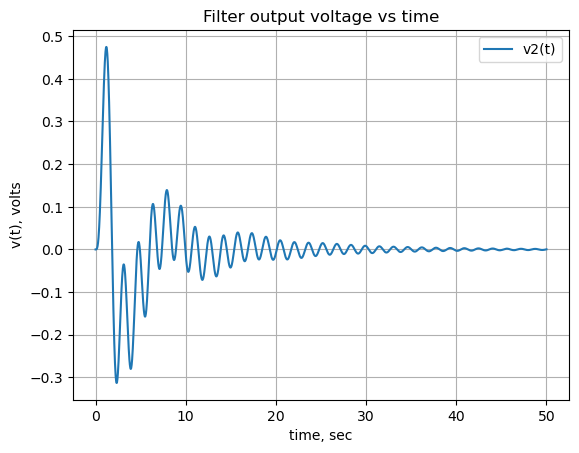

In [343]:
plt.title('Filter output voltage vs time')

plt.plot(x, np.real(V_node2),label='v2(t)')
#plt.plot(x, np.real(func_V1_t(x)),label='V1(t)')

plt.ylabel('v(t), volts')
plt.xlabel('time, sec')

plt.legend()
plt.grid()
plt.show()

## Capacitor charge
equalivent to position

### Voltage across C6

v9-v10

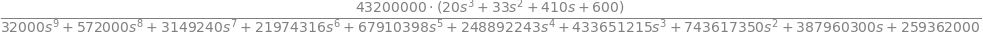

In [344]:
C6_voltage_s = (U[v9] - U[v10]).nsimplify().simplify().expand().together()
C6_voltage_s

The inverse Laplace was taking too long, so the lines of code were commented out

In [346]:
#C6_voltage = inverse_laplace_transform(C6_voltage_s, s, t)
#C6_voltage

Using NumPy to obtain the partial fraction expansion, convert back to the s domain and then take the inverse Laplace transform on each term.

Extract the numerator and denominator and display.

In [347]:
n, d = fraction(C6_voltage_s)
n = n.expand()
Markdown('numerator: ${:s}$<br>denominator: ${:s}$'.format(latex(n),latex(d)))

numerator: $864000000 s^{3} + 1425600000 s^{2} + 17712000000 s + 25920000000$<br>denominator: $32000 s^{9} + 572000 s^{8} + 3149240 s^{7} + 21974316 s^{6} + 67910398 s^{5} + 248892243 s^{4} + 433651215 s^{3} + 743617350 s^{2} + 387960300 s + 259362000$

Each of the numerator terms can be put over the common denominator.

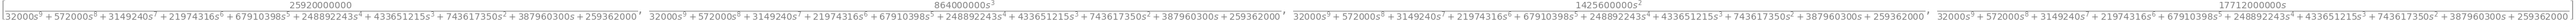

In [348]:
terms = [a / d for a in n.args]
display(terms)

The following code processes each of the terms obtained above. 

- the SciPy function [residue](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.residue.html) is used to get the residues and poles of the partial-fraction expansion
- build the partial expansion terms and find the inverse Laplace of each term and save

Returns:

- r: Residues corresponding to the poles. For repeated poles, the residues are ordered to correspond to ascending by power fractions.
- p: Poles ordered by magnitude in ascending order.
- k: Coefficients of the direct polynomial term.

When computing the inverse Laplace transform, the Coefficients (k) are ignored since these transform to a Dirac delta function, $\delta (t)$ and don't need to be plotted.

In [349]:
N = []

for p1 in terms:

    # use the SciPy residue function to get the partial-fraction expansion residues and poles
    n, d = fraction(p1)
    cn = Poly(n, s).all_coeffs()
    cd = Poly(d, s).all_coeffs()
    r, p, k = signal.residue(cn, cd, tol=0.001, rtype='avg')

    # build a symbolic expression for each of the residues and find the inverse Laplace of each one and save
    z = 0
    for i in range(len(r)):
        m = (r[i]/(s-p[i]))
        z += inverse_laplace_transform(m, s, t)

    N.append(z)

Each of these terms came be converted to a function using SymPy's [lambdify](https://docs.sympy.org/latest/modules/utilities/lambdify.html) function.

Define the values for the x-axis of the plot and put each one into an array for plotting.

In [350]:
x = np.linspace(0, 50, 2000, endpoint=True)
V_node2 = np.zeros(len(x),dtype = complex)
for p in N:
    V_node2 += lambdify(t, p)(x)

Plot the final combined result.

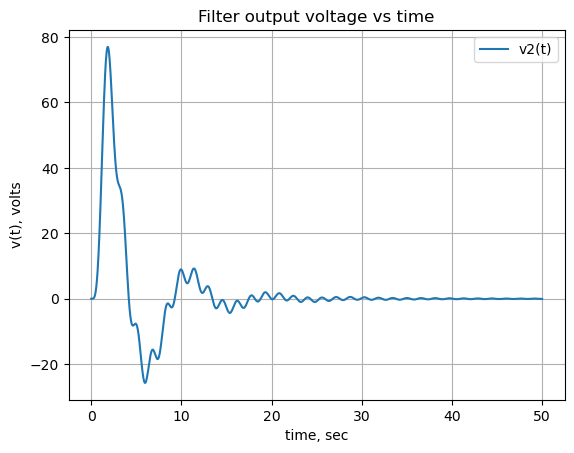

In [351]:
plt.title('Filter output voltage vs time')

plt.plot(x, np.real(V_node2),label='v2(t)')
#plt.plot(x, np.real(func_V1_t(x)),label='V1(t)')

plt.ylabel('v(t), volts')
plt.xlabel('time, sec')

plt.legend()
plt.grid()
plt.show()

### Voltage across C5

v7-v8

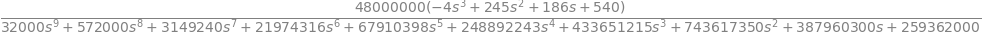

In [17]:
C5_voltage_s = (U[v7] - U[v8]).nsimplify().simplify().expand().together()
C5_voltage_s

The inverse Laplace was taking too long, so the lines of code were commented out

In [18]:
#C5_voltage = inverse_laplace_transform(C5_voltage_s, s, t)
#C5_voltage

Using NumPy to obtain the partial fraction expansion, convert back to the s domain and then take the inverse Laplace transform on each term.

Extract the numerator and denominator and display.

In [19]:
n, d = fraction(C5_voltage_s)
n = n.expand()
Markdown('numerator: ${:s}$<br>denominator: ${:s}$'.format(latex(n),latex(d)))

numerator: $- 192000000 s^{3} + 11760000000 s^{2} + 8928000000 s + 25920000000$<br>denominator: $32000 s^{9} + 572000 s^{8} + 3149240 s^{7} + 21974316 s^{6} + 67910398 s^{5} + 248892243 s^{4} + 433651215 s^{3} + 743617350 s^{2} + 387960300 s + 259362000$

Each of the numerator terms can be put over the common denominator.

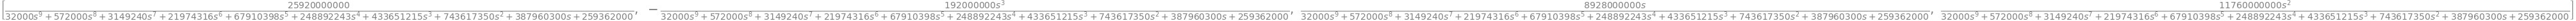

In [20]:
terms = [a / d for a in n.args]
display(terms)

The following code processes each of the terms obtained above. 

- the SciPy function [residue](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.residue.html) is used to get the residues and poles of the partial-fraction expansion
- build the partial expansion terms and find the inverse Laplace of each term and save

Returns:

- r: Residues corresponding to the poles. For repeated poles, the residues are ordered to correspond to ascending by power fractions.
- p: Poles ordered by magnitude in ascending order.
- k: Coefficients of the direct polynomial term.

When computing the inverse Laplace transform, the Coefficients (k) are ignored since these transform to a Dirac delta function, $\delta (t)$ and don't need to be plotted.

In [21]:
N = []

for p1 in terms:

    # use the SciPy residue function to get the partial-fraction expansion residues and poles
    n, d = fraction(p1)
    cn = Poly(n, s).all_coeffs()
    cd = Poly(d, s).all_coeffs()
    r, p, k = signal.residue(cn, cd, tol=0.001, rtype='avg')

    # build a symbolic expression for each of the residues and find the inverse Laplace of each one and save
    z = 0
    for i in range(len(r)):
        m = (r[i]/(s-p[i]))
        z += inverse_laplace_transform(m, s, t)

    N.append(z)

Each of these terms came be converted to a function using SymPy's [lambdify](https://docs.sympy.org/latest/modules/utilities/lambdify.html) function.

Define the values for the x-axis of the plot and put each one into an array for plotting.

In [22]:
x = np.linspace(0, 50, 2000, endpoint=True)
V_node2 = np.zeros(len(x),dtype = complex)
for p in N:
    V_node2 += lambdify(t, p)(x)

Plot the final combined result.

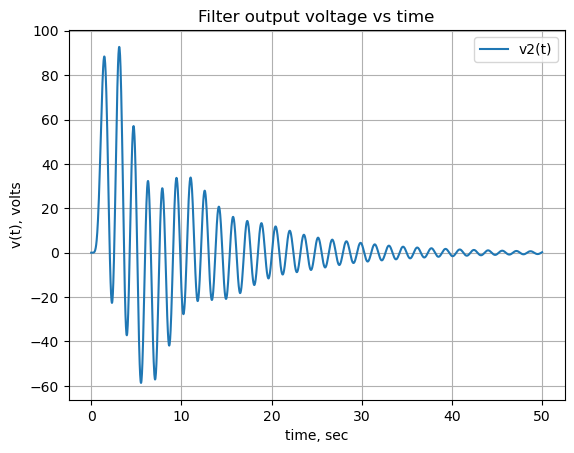

In [23]:
plt.title('Filter output voltage vs time')

plt.plot(x, np.real(V_node2),label='v2(t)')
#plt.plot(x, np.real(func_V1_t(x)),label='V1(t)')

plt.ylabel('v(t), volts')
plt.xlabel('time, sec')

plt.legend()
plt.grid()
plt.show()

### Voltage across C4

v4-v5

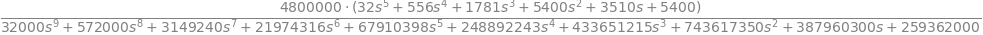

In [55]:
C4_voltage_s = (U[v4] - U[v5]).nsimplify().simplify().expand().together()
C4_voltage_s

The inverse Laplace was taking too long, so the lines of code were commented out

In [56]:
#C4_voltage = inverse_laplace_transform(C4_voltage_s, s, t)
#C4_voltage

Using NumPy to obtain the partial fraction expansion, convert back to the s domain and then take the inverse Laplace transform on each term.

Extract the numerator and denominator and display.

In [57]:
n, d = fraction(C5_voltage_s)
n = n.expand()
Markdown('numerator: ${:s}$<br>denominator: ${:s}$'.format(latex(n),latex(d)))

numerator: $- 192000000 s^{3} + 11760000000 s^{2} + 8928000000 s + 25920000000$<br>denominator: $32000 s^{9} + 572000 s^{8} + 3149240 s^{7} + 21974316 s^{6} + 67910398 s^{5} + 248892243 s^{4} + 433651215 s^{3} + 743617350 s^{2} + 387960300 s + 259362000$

Each of the numerator terms can be put over the common denominator.

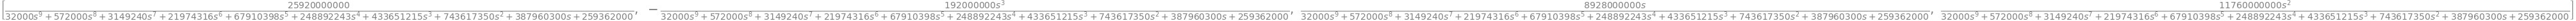

In [58]:
terms = [a / d for a in n.args]
display(terms)

The following code processes each of the terms obtained above. 

- the SciPy function [residue](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.residue.html) is used to get the residues and poles of the partial-fraction expansion
- build the partial expansion terms and find the inverse Laplace of each term and save

Returns:

- r: Residues corresponding to the poles. For repeated poles, the residues are ordered to correspond to ascending by power fractions.
- p: Poles ordered by magnitude in ascending order.
- k: Coefficients of the direct polynomial term.

When computing the inverse Laplace transform, the Coefficients (k) are ignored since these transform to a Dirac delta function, $\delta (t)$ and don't need to be plotted.

In [59]:
N = []

for p1 in terms:

    # use the SciPy residue function to get the partial-fraction expansion residues and poles
    n, d = fraction(p1)
    cn = Poly(n, s).all_coeffs()
    cd = Poly(d, s).all_coeffs()
    r, p, k = signal.residue(cn, cd, tol=0.001, rtype='avg')

    # build a symbolic expression for each of the residues and find the inverse Laplace of each one and save
    z = 0
    for i in range(len(r)):
        m = (r[i]/(s-p[i]))
        z += inverse_laplace_transform(m, s, t)

    N.append(z)

Each of these terms came be converted to a function using SymPy's [lambdify](https://docs.sympy.org/latest/modules/utilities/lambdify.html) function.

Define the values for the x-axis of the plot and put each one into an array for plotting.

In [60]:
x = np.linspace(0, 50, 2000, endpoint=True)
V_node2 = np.zeros(len(x),dtype = complex)
for p in N:
    V_node2 += lambdify(t, p)(x)

Plot the final combined result.

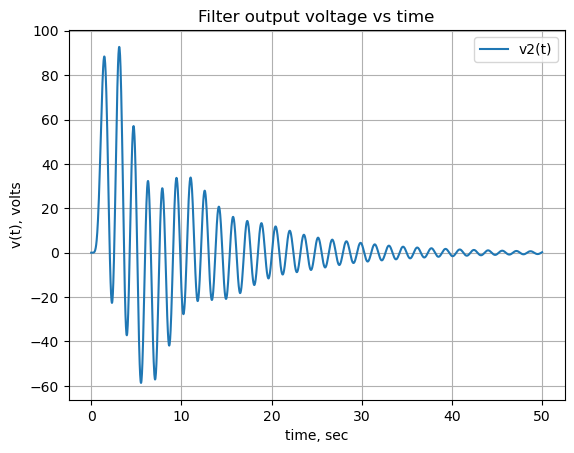

In [61]:
plt.title('Filter output voltage vs time')

plt.plot(x, np.real(V_node2),label='v2(t)')
#plt.plot(x, np.real(func_V1_t(x)),label='V1(t)')

plt.ylabel('v(t), volts')
plt.xlabel('time, sec')

plt.legend()
plt.grid()
plt.show()

### Voltage across Ceq

v3-v4

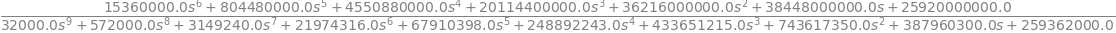

In [45]:
U[v3]

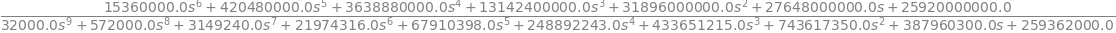

In [46]:
U[v4]

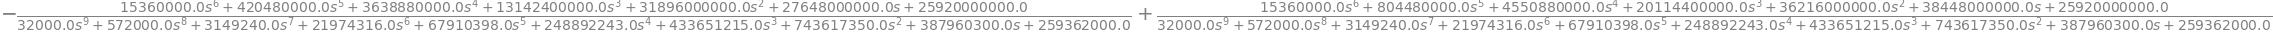

In [47]:
(U[v3] - U[v4])

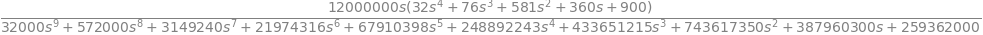

In [48]:
Ceq_voltage_s = (U[v3] - U[v4]).nsimplify().simplify().expand().together()
Ceq_voltage_s

The inverse Laplace 

Using NumPy to obtain the partial fraction expansion, convert back to the s domain and then take the inverse Laplace transform on each term.

Extract the numerator and denominator and display.

In [49]:
n, d = fraction(Ceq_voltage_s)
n = n.expand()
Markdown('numerator: ${:s}$<br>denominator: ${:s}$'.format(latex(n),latex(d)))

numerator: $384000000 s^{5} + 912000000 s^{4} + 6972000000 s^{3} + 4320000000 s^{2} + 10800000000 s$<br>denominator: $32000 s^{9} + 572000 s^{8} + 3149240 s^{7} + 21974316 s^{6} + 67910398 s^{5} + 248892243 s^{4} + 433651215 s^{3} + 743617350 s^{2} + 387960300 s + 259362000$

Each of the numerator terms can be put over the common denominator.

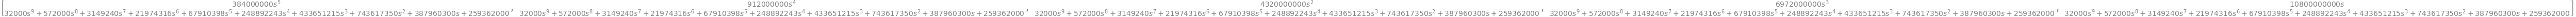

In [50]:
terms = [a / d for a in n.args]
display(terms)

The following code processes each of the terms obtained above. 

- the SciPy function [residue](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.residue.html) is used to get the residues and poles of the partial-fraction expansion
- build the partial expansion terms and find the inverse Laplace of each term and save

Returns:

- r: Residues corresponding to the poles. For repeated poles, the residues are ordered to correspond to ascending by power fractions.
- p: Poles ordered by magnitude in ascending order.
- k: Coefficients of the direct polynomial term.

When computing the inverse Laplace transform, the Coefficients (k) are ignored since these transform to a Dirac delta function, $\delta (t)$ and don't need to be plotted.

In [51]:
N = []

for p1 in terms:

    # use the SciPy residue function to get the partial-fraction expansion residues and poles
    n, d = fraction(p1)
    cn = Poly(n, s).all_coeffs()
    cd = Poly(d, s).all_coeffs()
    r, p, k = signal.residue(cn, cd, tol=0.001, rtype='avg')

    # build a symbolic expression for each of the residues and find the inverse Laplace of each one and save
    z = 0
    for i in range(len(r)):
        m = (r[i]/(s-p[i]))
        z += inverse_laplace_transform(m, s, t)

    N.append(z)

Each of these terms came be converted to a function using SymPy's [lambdify](https://docs.sympy.org/latest/modules/utilities/lambdify.html) function.

Define the values for the x-axis of the plot and put each one into an array for plotting.

In [52]:
x = np.linspace(0, 50, 2000, endpoint=True)
V_node2 = np.zeros(len(x),dtype = complex)
for p in N:
    V_node2 += lambdify(t, p)(x)

Plot the final combined result.

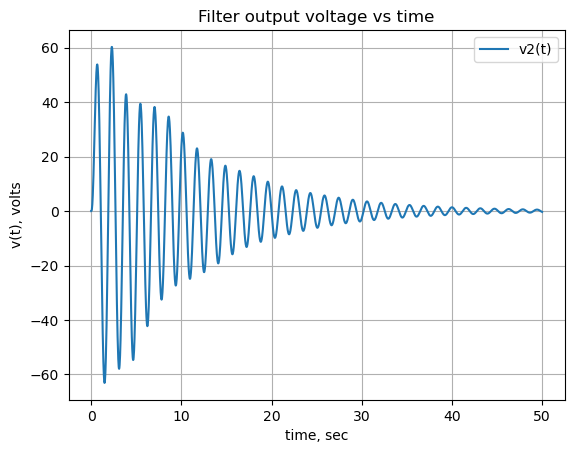

In [54]:
plt.title('Filter output voltage vs time')

plt.plot(x, np.real(V_node2),label='v2(t)')
#plt.plot(x, np.real(func_V1_t(x)),label='V1(t)')

plt.ylabel('v(t), volts')
plt.xlabel('time, sec')

plt.legend()
plt.grid()
plt.show()

### Voltage across C1

v1-v2

In [37]:
U[v1]

In [38]:
U[v2]

In [44]:
(U[v1] - U[v2])

In [31]:
C1_voltage_s = (U[v1] - U[v2]).nsimplify().simplify().expand().together()
C1_voltage_s

The inverse Laplace 

In [32]:
C1_voltage = inverse_laplace_transform(C1_voltage_s, s, t)
C1_voltage

In [33]:
V_node2 = lambdify(t, C1_voltage) 

In [35]:
x = np.linspace(0, 50, 2000, endpoint=True)

Plot the final combined result.

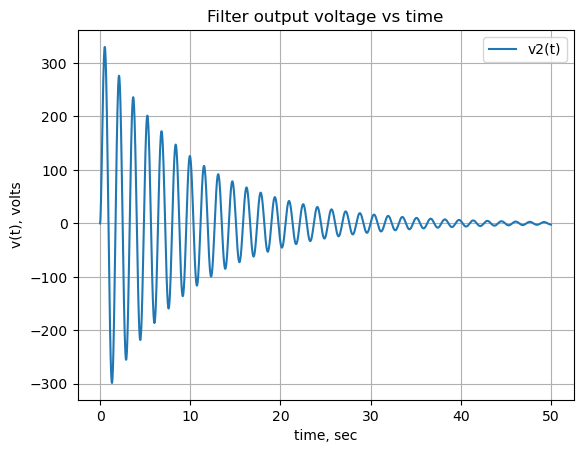

In [36]:
plt.title('Filter output voltage vs time')

plt.plot(x, np.real(V_node2(x)),label='v2(t)')
#plt.plot(x, np.real(func_V1_t(x)),label='V1(t)')

plt.ylabel('v(t), volts')
plt.xlabel('time, sec')

plt.legend()
plt.grid()
plt.show()

## Summary
test